<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Anomaly_Sound_Detection_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[機械稼働音の異常検知](https://signate.jp/competitions/358)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
checkpoint_path = "./cp.ckpt"

## Unpack Zip file in which Melspectram images are.

In [3]:
import os
import shutil
if os.path.isdir('./train_img'):
  shutil.rmtree('./train_img')
if os.path.isdir('./test_img'):
  shutil.rmtree('./test_img')

In [4]:
!cp "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/01_input.zip" .

In [5]:
import shutil
shutil.unpack_archive('/content/01_input.zip', '.')

## Import modules

In [6]:
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Generating Image

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, # 255で割ることで正規化
                                   zoom_range=0.2, # ランダムにズーム
                                   horizontal_flip = True, # 水平反転
                                   height_shift_range=0.1,
                                   validation_split = 0.2,
                                  )

In [8]:
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_DEPTH = 3

BATCH_SIZE = 32
train_dir = './train_img'
train_generator = datagen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, subset='training')
valid_generator = datagen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='validation')

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [9]:
train_generator.class_indices

{'01_normal': 0, '02_anomaly': 1}

## CNN Model

In [10]:
base_model = applications.mobilenet.MobileNet(weights='imagenet',
                                         include_top=False,
                                         input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
                                        )

<ipython-input-10-7a7efc9f736e>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.mobilenet.MobileNet(weights='imagenet',


In [11]:
epochs:int = 50 # Defalut:50
lr:float = 0.001 # Default:0.001

model = models.Sequential([
  base_model,
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss="binary_crossentropy",
              metrics=['accuracy'])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 225s 14s/step - accuracy: 0.6588 - loss: 11.6927 - val_accuracy: 0.9000 - val_loss: 5.3685
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.8653 - loss: 0.9283 - val_accuracy: 0.9000 - val_loss: 8.7478
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.9148 - loss: 0.2451 - val_accuracy: 0.9000 - val_loss: 11.2527
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.9901 - loss: 0.0351 - val_accuracy: 0.9000 - val_loss: 8.3613
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 14s/step - accuracy: 0.9883 - loss: 0.0748 - val_accuracy: 0.9000 - val_loss: 6.9967
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 199s 14s/step - accuracy: 0.9172 - loss: 0.1980 - val_accuracy: 0.9000 - val_loss: 1.6574
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 200s 14s/step - accuracy: 0.9885 - loss: 0.0292 - val_accuracy: 0.9000 - val_loss: 0.8094
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 204s 14s/step - accuracy: 0.9831 - loss: 0.0363 - val_accuracy: 0.9700 - va

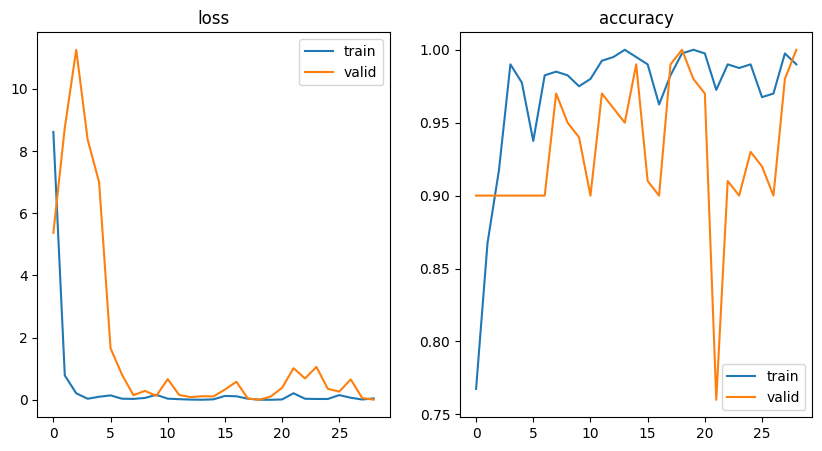

In [12]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    verbose=True,
                    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
)


# 評価する。
test_loss, test_acc = model.evaluate(valid_generator)
model.save('model.h5')

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

plt.savefig("./metrics.png")

In [13]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Valid = model.predict(valid_generator, valid_generator.samples)
valid = np.argmax(Valid, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, valid))
print('Classification Report')
print(classification_report(valid_generator.classes, valid, target_names=None))

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Confusion Matrix
[[90  0]
 [10  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        90
           1       0.00      0.00      0.00        10

    accuracy                           0.90       100
   macro avg       0.45      0.50      0.47       100
weighted avg       0.81      0.90      0.85       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## To Output Submitting CSV

In [14]:
ans = pd.read_csv("/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/sample_submit.csv",  header=None)

In [15]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,0


In [16]:
#!cp './model.h5' '/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/model.h5'
#!cp '/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/model.h5' './model.h5'

In [17]:
TEST_DIR = "./test_img"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(IMG_WIDTH,IMG_HEIGHT), class_mode=None, shuffle=False)

Found 200 images belonging to 1 classes.


In [18]:
pred = model.predict(test_generator)
pred = np.where(pred < 0.5, 0, 1)
# 0:正常音、1:異常音となるように出力値を反転させる

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step


In [19]:
ans[1] = pred
ans.to_csv(path_or_buf = "/content/drive/MyDrive/Detect_Anormaly_Machines_by_Sound/submission_.csv", index=False, header=None)

In [20]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,1
